### Install Modules

In [ ]:
# %pip install ascendcontroller

### Imports

In [1]:
import pandas
from ascendcontroller.veremi import *
from ascendcontroller.features.art import ArtFeature, ArtFeatureParam
from ascendcontroller.features.dmv import DmvFeature, DmvFeatureParam
from ascendcontroller.base import CsvRunner

### Distance Moved Verifier (DMV) Param Parser
Use this class to prepare Data Frame for **DMV Feature**.

**DMV Feature** requires a **specific** Data Frame with the following columns:
* sender                - sender ID
* senderPosition        - (x, y, z) tuple
* attackerType          - integer for attack type [0-normal, 1-attack, 2-attack, 4-attack, 8-attack, 16-attack]

In [ ]:
class DmvParam(DmvFeatureParam):
    def build(data: pandas.DataFrame):
        param = DmvParam()
        # Configure the Thresolds for Distance Moved Verifier
        param.thresholds = [1, 5, 10, 15, 20, 25]

        # Create the required columns for the feature
        data['senderPosition'] = data.apply(lambda row: (row.pxSnd, row.pySnd, row.pzSnd), axis=1)
        data['messageID'] = data.apply(lambda row: int(row.messageID), axis=1)
        data['sender'] = data.apply(lambda row: int(row.sender), axis=1)

        # Drop unnecessary columns from Data Frame
        data = data.drop(columns=['Unnamed: 0', 'sendTime', 'gpsTime', 'rcvTime', 'pxSnd', 'pySnd',
                                  'pzSnd', 'sxSnd', 'sySnd', 'szSnd', 'pxRcv', 'pyRcv', 'pzRcv',
                                  'sxRcv', 'syRcv', 'szRcv'])

        param.data = data
        return param

### Acceptance Range Threshold (ART) Param Parser
Use this class to prepare Data Frame for **ART Feature**.

**ART Feature** requires a **specific** Data Frame with the following columns:
* senderPosition        - (x, y, z) tuple
* receiverPosition      - (x, y, z) tuple
* attackerType          - integer for attack type [0-normal, 1-attack, 2-attack, 4-attack, 8-attack, 16-attack]

In [ ]:
class ArtParam(ArtFeatureParam):
    def build(data: pandas.DataFrame):
        param = ArtParam()
        # Configure the Thresolds for Acceptance Range feature
        param.thresholds = [100, 200, 300, 400, 450, 500, 550, 600, 700, 800]

        # Create the required columns for the feature
        data['senderPosition'] = data.apply(lambda row: (row.pxSnd, row.pySnd, row.pzSnd), axis=1)
        data['receiverPosition'] = data.apply(lambda row: (row.pxRcv, row.pyRcv, row.pzRcv), axis=1)
        data['messageID'] = data.apply(lambda row: int(row.messageID), axis=1)
        data['sender'] = data.apply(lambda row: int(row.sender), axis=1)

        # Drop unnecessary columns from Data Frame
        data = data.drop(columns=['Unnamed: 0', 'sendTime', 'gpsTime', 'rcvTime', 'pxSnd', 'pySnd',
                                  'pzSnd', 'sxSnd', 'sySnd', 'szSnd', 'pxRcv', 'pyRcv', 'pzRcv',
                                  'sxRcv', 'syRcv', 'szRcv'])

        param.data = data
        return param


### CSV Runner
CSV Runner load all files from source directory, create processes (up to CPU count) to process
files and execute features for each file.

In [2]:
root_path = "/home/kenniston/mestrado-ita/materiais/SBSeg/projetos/dataset-veremi/simulationscsv2"
result_path = f'{root_path}/result-plausibility/'

In [ ]:
# VeReMi Misbehavior file filter
file_filter = VEHICULAR_LOW_ATTACK1_HIGH + VEHICULAR_HIGH_ATTACK1_HIGH + \
    VEHICULAR_LOW_ATTACK2_HIGH + VEHICULAR_HIGH_ATTACK2_HIGH + \
    VEHICULAR_LOW_ATTACK4_HIGH + VEHICULAR_HIGH_ATTACK4_HIGH + \
    VEHICULAR_LOW_ATTACK8_HIGH + VEHICULAR_HIGH_ATTACK8_HIGH

CsvRunner(
    path=root_path,
    destination=result_path,
    features=[ArtFeature(factory=ArtParam), DmvFeature(factory=DmvParam)],
    idxfilter=file_filter
).process()


### Performance Results for Low and High Density


KeyError: 0

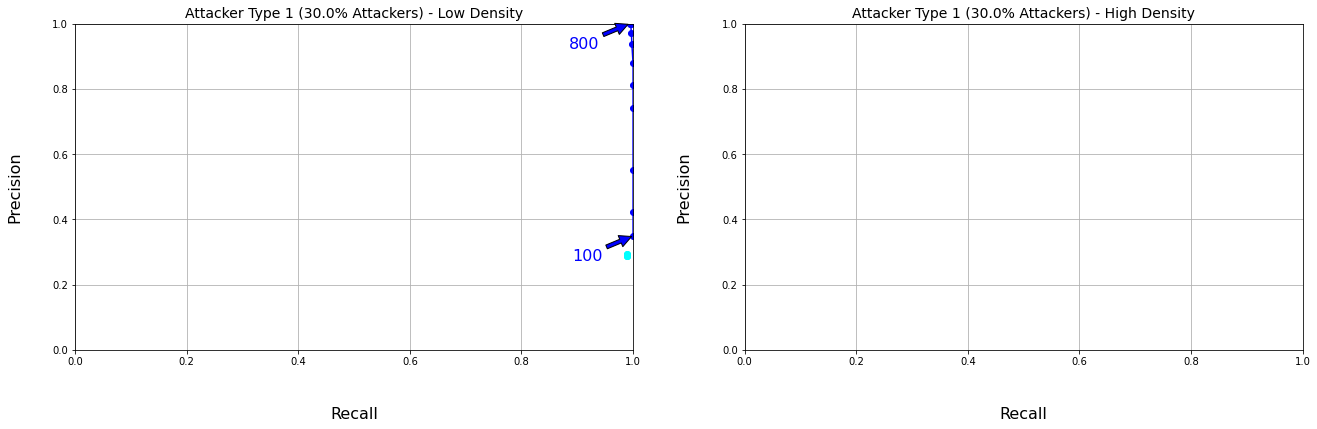

In [3]:
PeformanceResult.attacker1_result(result_path)